In [1]:
import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn           as sns

import re

import nltk
from   nltk.stem   import WordNetLemmatizer
from   nltk.corpus import stopwords

from   sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from   sklearn.ensemble        import RandomForestClassifier
from   sklearn.tree            import DecisionTreeClassifier
from   sklearn.neural_network  import MLPClassifier

from   sklearn.feature_extraction.text import TfidfVectorizer

from   sklearn.metrics import classification_report, accuracy_score, hamming_loss, multilabel_confusion_matrix

import pickle

In [2]:
# CONFIG

pd.options.display.max_columns = None
pd.options.display.max_rows    = None


TRAIN_SIZE       = 0.95

VEC_NGRAM_RANGE  = (1, 3)
VEC_SMOOTH_IDF   = True
VEC_SUBLINEAR_TF = True


TRAIN_N_RFTREES  = 10


TRAIN_DECI_TREE_CRITERION = "gini"


TRAIN_MLPC_SOLVER = "adam" # ??
TRAIN_MLPC_EPOCHS = 1 # ??

In [3]:
# load dataset "GoEmotions" : https://github.com/google-research/google-research/tree/master/goemotions/data/full_dataset
# https://arxiv.org/pdf/2005.00547.pdf

df1 = pd.read_csv("../../datasets/goemotions_1.csv")
df2 = pd.read_csv("../../datasets/goemotions_2.csv")
df3 = pd.read_csv("../../datasets/goemotions_3.csv")

# merge all the three segments into one pd.DataFrame
df  = pd.concat([df1, df2, df3])

print("shape: ", df.shape)
df.tail()

shape:  (211225, 37)


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
71220,Everyone likes [NAME].,ee6pagw,Senshado,heroesofthestorm,t3_agjf24,t3_agjf24,1.547634e+09,16,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
71221,Well when you’ve imported about a gazillion of...,ef28nod,5inchloser,nottheonion,t3_ak26t3,t3_ak26t3,1.548553e+09,15,False,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71222,That looks amazing,ee8hse1,springt1me,shittyfoodporn,t3_agrnqb,t3_agrnqb,1.547684e+09,70,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71223,The FDA has plenty to criticize. But like here...,edrhoxh,enamedata,medicine,t3_aejqzd,t1_edrgdtx,1.547169e+09,4,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71224,Desktop link: ^^/r/HelperBot_ ^^Downvote ^^to ...,edze9g4,HelperBot_,MorbidReality,t3_afhw30,t1_edze91s,1.547397e+09,61,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# clean-up dataset

df = df.drop(columns=["id", "author", "subreddit", "link_id", "parent_id", "created_utc", "rater_id"])  # only account for useful columns
df = df[df["example_very_unclear"] == False]    # ignore "unclear" rows
df = df.drop(columns=["example_very_unclear"])  # drop this column


print("shape: ", df.shape)
print("null values: ", df.isnull().sum().sum())

shape:  (207814, 29)
null values:  0


In [5]:
# data pre-processing

nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words("english")


def preprocess(text):
    res = str()

    
    text = text.lower()

    # regexes
    url = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    usr_name = r"@[^\s]+"
    non_numalpha = r"[^a-zA-Z0-9]"

    # apply them
    text = re.sub(url, " URL", text)        # remove urls
    text = re.sub(usr_name, " USER", text)  # remove user tags
    text = re.sub(non_numalpha, " ", text)  # remove special chars

    
    # remove stopwords and lemmatize  the rest
    for token in text.split():
        if token not in stop_words:
            token = lemmatizer.lemmatize(token)
            res += (token + ' ')

    return res




df.text = df.text.apply(lambda x : preprocess(x))
df.tail()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/b1kestar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/b1kestar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
71219,well glad awful way act make think healthy bou...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
71220,everyone like name,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
71221,well imported gazillion country get serious,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71222,look amazing,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71223,fda plenty criticize like usually criticized h...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# save labels to txt file for frontend use

np.savetxt("../model/emotions.csv", [df.columns[1:]], fmt="%s")

In [7]:
# split the dataset into training data (95%) and testing data (5%)

X_train_text, X_test_text, y_train_target, y_test_target = train_test_split(df["text"], df[df.columns[1:]], test_size=1-TRAIN_SIZE, random_state=0)


print("Dataset Size:       ", len(df))
print("Training Data Size: ", len(X_train_text))
print("Testing Data Size:  ", len(X_test_text))

Dataset Size:        207814
Training Data Size:  197423
Testing Data Size:   10391


In [8]:
# vectorize
vectorizer = TfidfVectorizer(ngram_range=VEC_NGRAM_RANGE, smooth_idf=VEC_SMOOTH_IDF, sublinear_tf=VEC_SUBLINEAR_TF)
vectorizer.fit(X_train_text)


# transform
X_train_text = vectorizer.transform(X_train_text)
X_test_text  = vectorizer.transform(X_test_text)

In [9]:
ngrams_accepted = vectorizer.get_feature_names_out()
ngrams_ignored  = vectorizer.stop_words_

print("Number of ngrams accepted (sizes: 1-3): ", len(ngrams_accepted))
print("Number of ngrams ignored  (sizes: 1-3): ", len(ngrams_ignored))

Number of ngrams accepted (sizes: 1-3):  521827
Number of ngrams ignored  (sizes: 1-3):  0


In [10]:
# save the vectorizer to disk

f = open("../model/vectorizer.pickle", "wb")
pickle.dump(vectorizer, f)
f.close()

In [11]:
def examine_model(model):
    y_pred = model.predict(X_test_text)
    
    print(classification_report(y_test_target, y_pred, zero_division=0))
    print("Hamming Loss: ", round(hamming_loss(y_test_target, y_pred), 4))
    

    labels = df.columns[1:]
    mlcm = multilabel_confusion_matrix(y_test_target, y_pred)
    
    fig, axs = plt.subplots(nrows=7, ncols=4)
    plt.subplots_adjust(wspace=0.5, hspace=0.9)
    fig.set_figheight(16)
    fig.set_figwidth(16)

    for i in range(len(labels)):
        group_names = ["True Neg.", "False Pos.", "False Neg.", "True Pos."]
        group_percs = ["{0:.2%}".format(value) for value in mlcm[i].flatten() / np.sum(mlcm[i])]
        annots = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_percs)]
        annots = np.asarray(annots).reshape(2, 2)
        
        sns.heatmap(data=mlcm[i], annot=annots, fmt="", cmap="Blues", cbar=False, ax=axs.flat[i])
        
        axs.flat[i].set_xlabel("Predicted")
        axs.flat[i].set_ylabel("Actual")
        axs.flat[i].title.set_text(labels[i])

    plt.show()

In [12]:
# TRAIN: Random Forest Classifier

RFCModel = RandomForestClassifier(verbose=100, n_jobs=-1, n_estimators=TRAIN_N_RFTREES)
RFCModel.fit(X_train_text, y_train_target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed: 50.4min remaining: 201.8min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 50.7min remaining: 118.3min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed: 51.5min remaining: 77.3min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 52.0min remaining: 52.0min
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 52.5min remaining: 35.0min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 52.5min remaining: 22.5min
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed: 52.5min remaining: 13.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 53.4min fini

RandomForestClassifier(n_estimators=10, n_jobs=-1, verbose=100)

Random Forest Classifier Model
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished
              precision    recall  f1-score   support

           0       0.54      0.42      0.47       843
           1       0.56      0.45      0.50       499
           2       0.41 

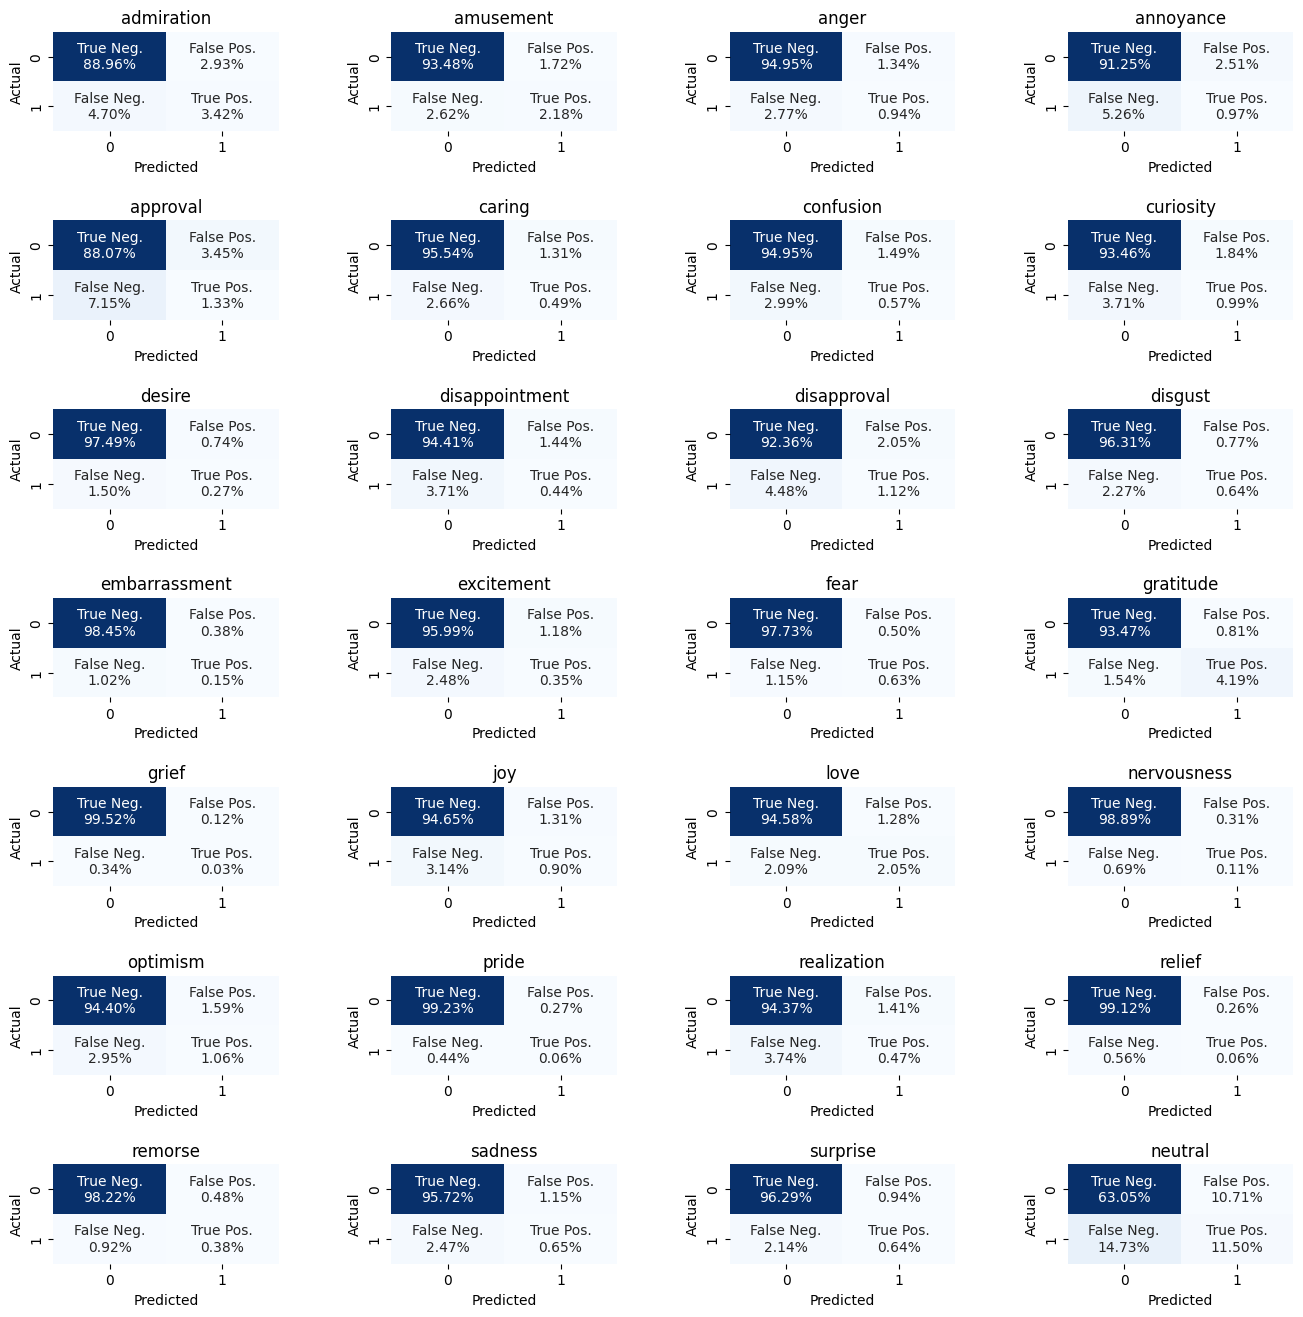

In [13]:
# examine Random Forest Classifier Model

print("Random Forest Classifier Model")
examine_model(RFCModel)

In [14]:
# save the Random Forest Classifier Model to disk

f = open("../model/RFCModel.pickle", "wb")
pickle.dump(RFCModel, f)
f.close()

In [15]:
# TRAIN: Decision Tree Classifier

DTCModel = DecisionTreeClassifier(criterion=TRAIN_DECI_TREE_CRITERION)
DTCModel.fit(X_train_text, y_train_target)

DecisionTreeClassifier()

Decision Tree Classifier Model
              precision    recall  f1-score   support

           0       0.57      0.31      0.40       843
           1       0.55      0.29      0.38       499
           2       0.46      0.16      0.24       386
           3       0.25      0.07      0.11       648
           4       0.33      0.09      0.14       881
           5       0.29      0.09      0.13       327
           6       0.34      0.11      0.16       370
           7       0.39      0.14      0.21       489
           8       0.36      0.09      0.15       184
           9       0.30      0.06      0.10       431
          10       0.39      0.12      0.18       581
          11       0.51      0.13      0.20       303
          12       0.40      0.10      0.16       122
          13       0.25      0.07      0.11       294
          14       0.66      0.31      0.42       184
          15       0.86      0.69      0.76       595
          16       0.25      0.03      0.05       

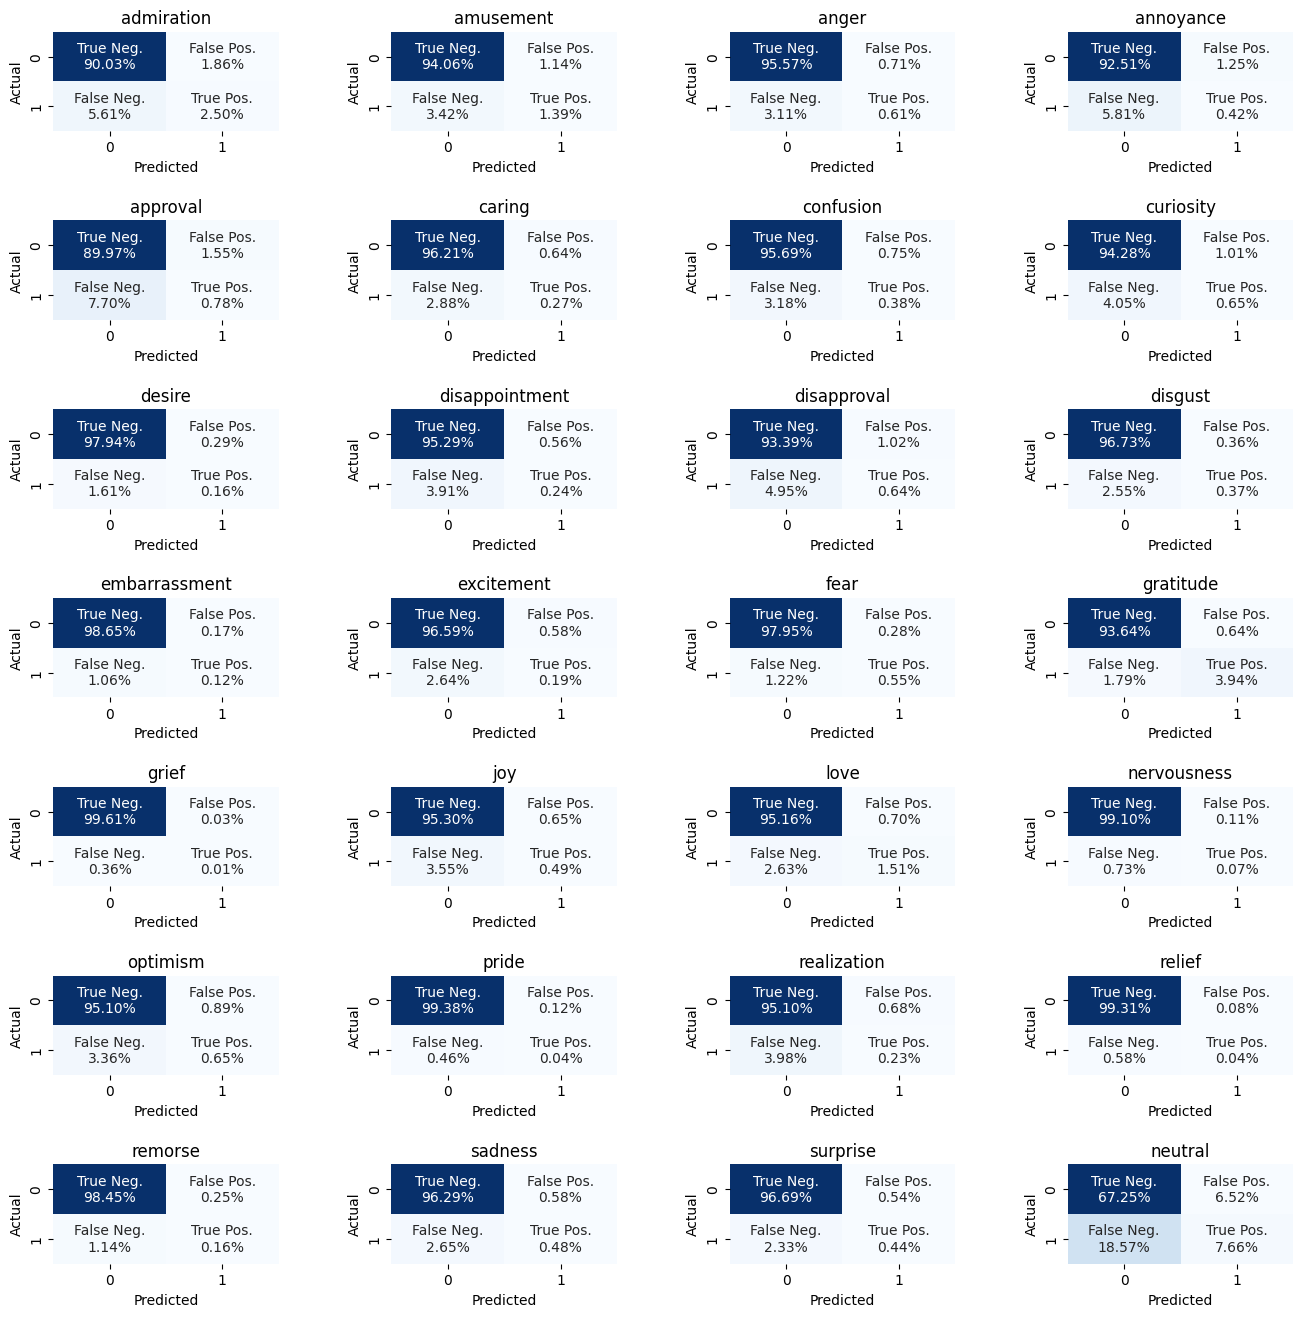

In [16]:
# examine Decision Tree Classifier Model

print("Decision Tree Classifier Model")
examine_model(DTCModel)

In [17]:
# save the Decision Tree Classifier Model to disk

f = open("../model/DTCModel.pickle", "wb")
pickle.dump(DTCModel, f)
f.close()

In [ ]:
# TRAIN: Neural Network - Multi-layer Perceptron Classifier

MLPCModel = MLPClassifier(solver=TRAIN_MLPC_SOLVER, max_iter=TRAIN_MLPC_EPOCHS)
MLPCModel.fit(X_train_text, y_train_target)

In [ ]:
# examine MLP Classifier Model

print("Neural Network: MLP Classifier Model")
examine_model(MLPCModel)

In [ ]:
# save the MLP Classifier Model to disk

f = open("../model/MLPCModel.pickle", "wb")
pickle.dump(MLPCModel, f)
f.close()

In [18]:
def gen_output_df(query_strs, model):
    X = vectorizer.transform(list(map(lambda x : preprocess(x), query_strs)))
    y = model.predict_proba(X)

    labels  = df.columns[1:]

    output_df = pd.DataFrame(columns=df.columns)

    # for all input strings
    for i in range(len(query_strs)):
        output_df.loc[i, df.columns[0]] = query_strs[i]    # record input text

        # for all labels
        for j in range(len(y)):
            output_df.loc[i, df.columns[j + 1]] = round(y[j][i][1] * 100, 2)    # record label probability

    
    return output_df




def vizualize_output_df(output_df):
    fig, axs = plt.subplots(nrows=output_df.shape[0], ncols=1)
    plt.subplots_adjust(hspace=0.5)
    fig.set_figheight(8 * output_df.shape[0])
    fig.set_figwidth(8)

    
    for i in range(output_df.shape[0]):
        axis = axs.flat[i]
        
        p = sns.barplot(data=output_df.loc[i, df.columns[1:]], ax=axis, color="dodgerblue")
        p.bar_label(p.containers[0], fmt=(lambda x: f"{round(x)}%" if x > 0 else ""), fontsize=6)
        
        axis.set_xlabel("LABELS")
        axis.set_ylabel("PROBABILITY (%)")
        axis.tick_params(axis='x', labelrotation=90)
        axis.set(ylim=(0, 100))
        axis.title.set_text("string: \"" + output_df.loc[i, df.columns[0]] + "\"\n")

    plt.show()

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


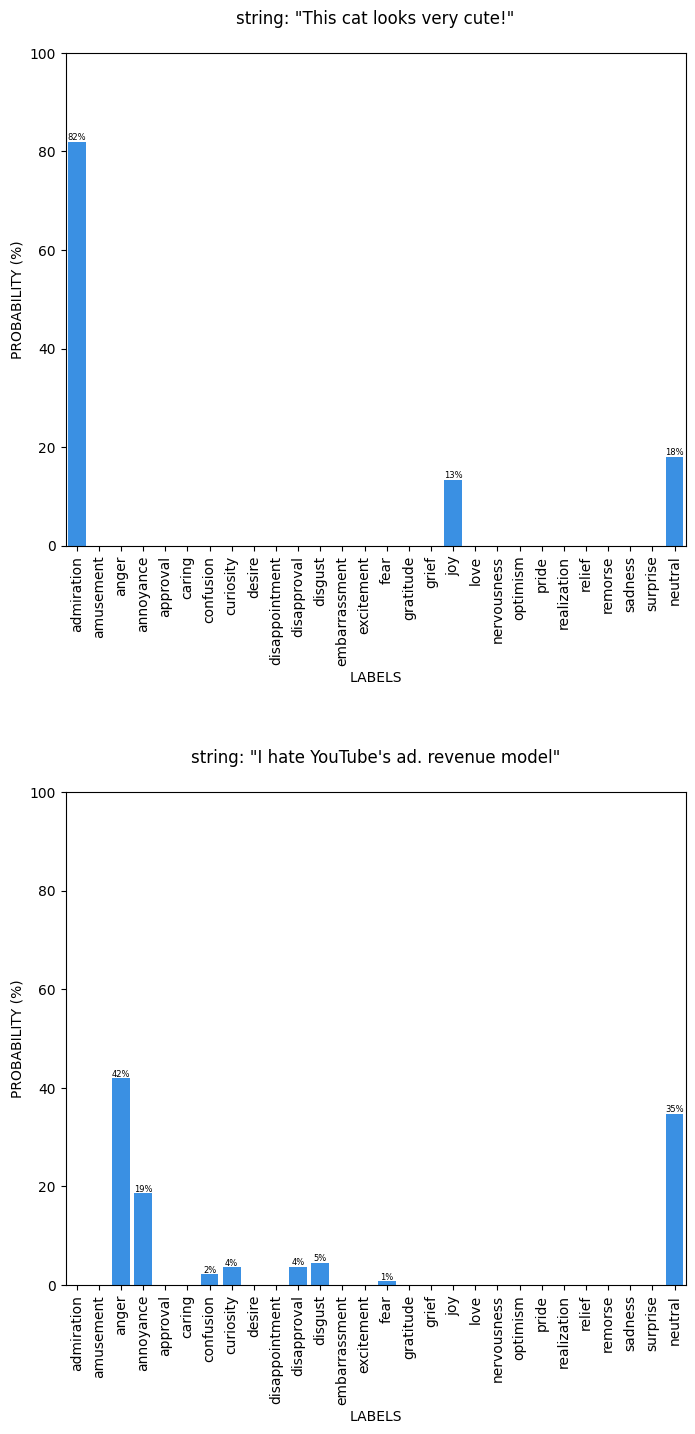

In [21]:
# at this stage, our model is ready. let's run some queries

query_strs = ["This cat looks very cute!", "I hate YouTube's ad. revenue model"]
model      = RFCModel

output_df  = gen_output_df(query_strs, model)

vizualize_output_df(output_df)

In [22]:
def predict_labels(query_strs, model):
    texts   = vectorizer.transform(list(map(lambda x : preprocess(x), query_strs)))
    targets = model.predict(texts)

    
    for i in range(len(query_strs)):
        text   = query_strs[i]
        target = targets[i]
        emotions = []
    
        print(text, end=" ===> ")
    
        for j in range(len(target)):
            if target[j] == 1:
                emotions.append(df.columns[1:][j])
    
        print(emotions)

In [23]:
predict_labels(query_strs, model)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
This cat looks very cute! ===> ['admiration']
I hate YouTube's ad. revenue model ===> []
